# Detectron2 for predicting the task

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


#`Install` some imperative functions for training the model

In [1]:
##### Import all necessity functions for Machine Learning #####
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as shc
import warnings
import zipfile
import cv2
import os
import random
from collections import Counter
from functools import reduce
from itertools import chain
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, chi2, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE, ADASYN
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, SGDRegressor, Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score, silhouette_score
from xgboost import XGBClassifier, XGBRegressor

##### Download keras #####
!pip install keras

##### Remove all warnings #####
import warnings
warnings.filterwarnings("ignore")

##### Import all necessity functions for Neural Network #####
import tensorflow as tf
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.layers import Dense, Conv2D, LSTM, GRU, RNN, Flatten, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU, ELU, PReLU
from keras.activations import tanh, relu, sigmoid, softmax, swish
from keras.regularizers import L1, L2, L1L2
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam, Adamax, Nadam
from keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, hinge, MSE, MAE, Huber
import keras.utils as image
from google.colab.patches import cv2_imshow
from keras.utils import plot_model

##### Plotting the confusion matrix #####
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from numpy.linalg import norm
from sklearn.neighbors import NearestNeighbors
from keras.utils import load_img, img_to_array

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Check the `runtime type` because I am using `Google Colab Pro`
####1. It provides me `Tesla T4` and `RAM` 25 GB, and `Disk` 166 GB 

In [2]:
!nvidia-smi

Tue Mar 21 12:49:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##`pwd` to confirm the current working directory



In [3]:
!pwd

/content


##The `ls` command allows us to quickly view all files within the specified directory

In [4]:
!ls

sample_data


#To access the `Google Drive` 

*  In that particular Drive, the images are presence - We should be extracted all images from the drive.

In [5]:
#### Import the liabries ####
from google.colab import drive
#### Define the function that would be responsible for access the drive ####
def access_drive(activate = None):
  if activate == 'activated':
    drive.mount('/content/drive')
  else:
    #### Raise the exception if there is an error ####
    raise Exception('There is an error.'.capitalize())

#### Call the current function ####
try:
  access_drive(activate = 'activated')
except Exception as e:
  print(e.with_traceback)
else:
  print('Acesss has been done.'.capitalize())

Mounted at /content/drive
Acesss has been done.


##`Move` the current directory so that I can `unzip` the train images, which is 25 images. In order to do this in Google Colab

*   run the command `cd` with the desired path where we want to redirect.

In [6]:
%cd /content/drive/MyDrive/detectron2maskrcnn

/content/drive/MyDrive/detectron2maskrcnn


##`Unzip` the training images and data annotation 

*  There are 25 Images presence with the `one` specific `json` because we are training this model using the MaskRCNN where it requires `data annotation` and the format of that annotation would be `json` format.

*  Initially, we take those 25 images and make them `label` using `labelme` software. Link: `https://github.com/wkentaro/labelme#installation`. Here, all the requirements has been written based on `Windows`, `Mac` users. The following command that I used to make them `label` using `labelme` software for the installation purpose.


                                                          * conda create --name=labelme python=3

                                                          * source activate labelme

                                                          * pip install labelme




Afterwards, I labelled them with the name of `roof` with the dataset of 25 images individually and stored them a folder named `labelmask`. The labelmask folder link is: `https://github.com/atikul-islam-sajib/dida_task/blob/main/labelmask.zip`. 

Though, I am using the `Detectron2` framework - Here, instead of taking one by one singular `json` format that I created using `labelme` software would not be applicable for the further. As a result, I should be converted that format with respect to `Detectron2`. So, I use `labelme2coco.py` function for changing the format. Link of this `labelme2coco.py` is: `https://github.com/atikul-islam-sajib/dida_task/blob/main/labelme2coco.py` - That usually found in internet to make the change. In addition, the following command I had to run to do this.

                                                    * conda activate labelme
                                                    * python labelme2coco.py labelmask --output train.json


This commands assist me to make the change and it just converted one single `json` file for all the `25` images that I should be used for the further training. The link of that `traindata` is : `https://github.com/atikul-islam-sajib/dida_task/blob/main/traindata.zip`

In [7]:
!unzip traindata.zip

Archive:  traindata.zip
   creating: traindata/images/
  inflating: traindata/images/121.png  
  inflating: traindata/images/241.png  
  inflating: traindata/images/270.png  
  inflating: traindata/images/272.png  
  inflating: traindata/images/274.png  
  inflating: traindata/images/278.png  
  inflating: traindata/images/284.png  
  inflating: traindata/images/287.png  
  inflating: traindata/images/300.png  
  inflating: traindata/images/301.png  
  inflating: traindata/images/303.png  
  inflating: traindata/images/308.png  
  inflating: traindata/images/314.png  
  inflating: traindata/images/315.png  
  inflating: traindata/images/317.png  
  inflating: traindata/images/320.png  
  inflating: traindata/images/324.png  
  inflating: traindata/images/328.png  
  inflating: traindata/images/337.png  
  inflating: traindata/images/343.png  
  inflating: traindata/images/345.png  
  inflating: traindata/images/379.png  
  inflating: traindata/images/381.png  
  inflating: traindata/im

# Install `detectron2` - all the files would be generated in the `Google` Drive 

In [8]:
#### Import some important liabries ####
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

#### Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities. ####
#### See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions ####
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

#### Properly install detectron2. (Please do not install twice in both ways) ####
#### !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' ####

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=e2bf585d5a62e84ed9f9327a1ac725df71792490ac9ce40a9be396a134563ddd
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
fatal: destination path 'detectron2' already exists and is not an empty directory

##Import some `necessity functions` for the further process

In [10]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

#### import some common libraries ####
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#### import some common detectron2 utilities ####
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

###Check the `Cuda` version and `torch` version as well 

In [11]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


#In order to check the `loaded` images is done perfectly or not

* `register_coco_instances` takes two parametes 
                      1. /content/drive/MyDrive/detectron2maskrcnn/traindata/ train.json
                      
                      There, my json format presence of all training 25 images

                      2./content/drive/MyDrive/detectron2maskrcnn/traindata/images

                      There, my images of 25 training are appeared.

In [12]:
#### Import the necessity functions #####
from detectron2.data.datasets import register_coco_instances
#### Define the functions #####
def loaded(activate = None):
  if activate == 'activated':
    #### This ` register_coco_instances` function will take the `json` path and `image` path ####
    register_coco_instances("MASKRCNN", {}, "/content/drive/MyDrive/detectron2maskrcnn/traindata/train.json",\
                            "/content/drive/MyDrive/detectron2maskrcnn/traindata/images")
    #### that function returns two parameters ####
    sample_metadata = MetadataCatalog.get("MASKRCNN")
    dataset_dicts = DatasetCatalog.get("MASKRCNN")
    return sample_metadata, dataset_dicts
  else:
    raise Exception('There is an error.'.capitalize())

#### Call the current function ####
try:
  sample_metadata, dataset_dicts = loaded(activate = 'activated')
except Exception as e:
  print(e)
else:
  print('All the functions works very well'.capitalize())

WARNING [03/21 13:36:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/21 13:36:55 d2.data.datasets.coco]: Loaded 25 images in COCO format from /content/drive/MyDrive/detectron2maskrcnn/traindata/train.json
All the functions works very well


####Check the Images

                              *  Check the uploaded image works perfectly or not 
                              * To do this, just take a `random` image from the Google Drive and try to print out

In [15]:
try:
  print(cv2.imread('/content/drive/MyDrive/detectron2maskrcnn/traindata/images/121.png'))
except Exception as e:
  print(e.with_traceback)
else:
  print('All are working well'.capitalize())

[[[ 57  64  57]
  [ 81  91  83]
  [ 61  66  61]
  ...
  [ 57  32  20]
  [ 58  33  22]
  [ 50  28  16]]

 [[ 66  70  59]
  [ 55  58  47]
  [ 49  47  36]
  ...
  [ 61  35  23]
  [ 56  29  18]
  [ 44  23  10]]

 [[ 48  51  45]
  [ 37  35  20]
  [ 57  46  37]
  ...
  [ 61  35  24]
  [ 52  25  13]
  [ 46  24  11]]

 ...

 [[ 76  85  71]
  [ 73  79  60]
  [ 64  68  52]
  ...
  [128 126 125]
  [133 131 130]
  [ 36  36  35]]

 [[ 78  91  80]
  [ 79  89  75]
  [ 73  80  65]
  ...
  [ 90  89  88]
  [109 107 106]
  [ 47  45  44]]

 [[ 85 101  92]
  [ 80  94  84]
  [ 62  74  60]
  ...
  [  0   0   0]
  [ 12  13  11]
  [ 21  17  14]]]
All are working well


####Check the `key` of `dataset_dicts` - because we will plot some of the random images from the `traindata`. 

*  Here, in that key there is `file_name` - using it we can plot the images

In [18]:
try:
  print(dataset_dicts[0].keys())
except Exception as e:
  print(e.with_traceback)
else:
  print('\nAll are perfect'.capitalize())

dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])

all are perfect


#Check the `random Images` from the `traindata`

                            * In `dataset_dicts` - we are taking the randomly 3 images and try to plot with their label


The random image is 1


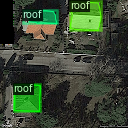

 
The random image is 2


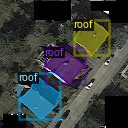

 
The random image is 3


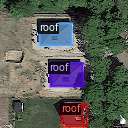

In [55]:
#### Import the random liabry ####
import random

def plot_images(activate = None):
  if activate == 'activated':
    #### Take the random 3 images from the traindata ####
    for index, d in enumerate(random.sample(dataset_dicts, 3)):
        print('\nThe random image is {}'.format(index + 1))
        #### This `imread` function responsible for the convert the images into NumPy array ####
        img = cv2.imread(d["file_name"])
        #### Visualize the images ####
        visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        ####Plot it #####
        cv2_imshow(vis.get_image()[:, :, ::-1])
        print("", end = " ")
    else:
      #### Raise the Exception ####
      raise Exception(''.capitalize())

#### Call the function ####

try:
   plot_images(activate = 'activated')
except Exception as e:
  print(e)

# Run a `pre-trained detectron2` model

* To do this, First of all, I should be access the `Model Zoo` of `Detectron2` and link of this: `https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md` link to use the model
* In there, I should be choosen `COCO Instance Segmentation Baselines with Mask R-CNN` because I am using `Segmentation Baseline`.

What is `Mask R-CNN` and Why?

* Mask R-CNN: `Mask R-CNN` is a state of the art model for instance segmentation, developed on top of `Faster R-CNN`. `Faster R-CNN` is a region-based convolutional neural networks, that returns bounding boxes for each object and its class label with a confidence score. In addition, `Mask R-CNN` uses anchor boxes to detect multiple objects, objects of different scales, and overlapping objects in an image. This improves the speed and efficiency for object detection. `Anchor boxes` are a set of predefined bounding boxes of a certain height and width. In our problem task, There are `30` images of satellite with the labeling of 25 images that indicates of `roof`. In this particular problem, We should be indicated the `roof` with the `ìnstance` segmentation.

* Why Mask R-CNN: `Faster R-CNN` can do the object detection but over the `Mask R-CNN` it is not only doing the object detection but also additionally implementing the image segmentation on image and it means segregating the pixels - means what all pixels belongs to which particular object. In addition, with the image segmentation we can specially tell that the exact position of the object.


Lastly, I use some of the `models` from the model zoo. 

                                1. COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
                                2. COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml
                                3. COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"


Among them, this `COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml` model give me the better performance among all. The parameters that I used and tuned is given below:

    * the `BASE_LR` = 0.002 (I used some combinations, for instance 0.001, 0.01, 0.005) - Among them, this 0.002 was given me the better perfomance.

    * the 'MAX_ITER' = 1000 (I also tried 300, 500, 700 and more or less all performace was quite good)

    * `NUM_CLASSES` = 1 (Due to, there is only classes that is `roof`)

    * `IMS_PER_BATCH` = 2 (Like, I tried with some others but this works better for me, Hyperparameter tuning.)


Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [24]:
#### Import all the necessity functions ####
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
##### Configure the model #####
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("MASKRCNN",)
#### no metrics implemented for this dataset ####
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
#### 1000 iterations seems good enough, but you can certainly train longer ####
cfg.SOLVER.MAX_ITER = 1000  
#### faster, and good enough for this toy dataset ####
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#### 1 class (Roof) #####
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[03/21 14:22:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

###checkpoint - `detection_checkpoint`

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#### set the testing threshold for this model ####
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("MASKRCNN", )
predictor = DefaultPredictor(cfg)

[03/21 14:23:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


#Check the performance of `train` dataset


The train image is 1


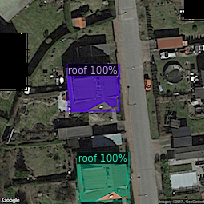

 
The train image is 2


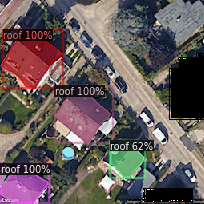

In [30]:
#### Import all necessity functions #####
from detectron2.utils.visualizer import ColorMode

def plot_train_performace(activate = None):
  if activate == "activated":
    for index, d in enumerate(random.sample(dataset_dicts, 2)):  
        print('\nThe train image is {}'.format(index + 1))  
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                      metadata=sample_metadata, 
                      scale=0.8
                      
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(v.get_image()[:, :, ::-1])
        print("", end = " ")
  else:
    raise Exception('Plotting is not possible'.capitalize())
  
#### Call the current function ####
try:
  plot_train_performace(activate = 'activated')
except Exception as e:
  print(e.with_traceback)


#Check the performance of `test` dataset

In [31]:
##### Change the directory path ####
%cd /content/drive/MyDrive/detectron2maskrcnn

/content/drive/MyDrive/detectron2maskrcnn


####`Unzip` the test testing folder - There are `5 images` presence

In [33]:
#### Unzip the file ####ny
!unzip testing.zip

Archive:  testing.zip
  inflating: testing/535.png         
  inflating: testing/537.png         
  inflating: testing/539.png         
  inflating: testing/551.png         
  inflating: testing/553.png         


##`Store` the test images into a list named `data` for the further 

In [34]:
#### Initialize the empty list ####
data = []

#### Declare, where the test images presence ####
_DIRECTORY = "/content/drive/MyDrive/detectron2maskrcnn/testing"

#### Store all the images to the data list ####
for test_image in os.listdir(_DIRECTORY):
  data.append(os.path.join(_DIRECTORY, test_image))

print("The data looks like: \n",data)

The data looks like: 
 ['/content/drive/MyDrive/detectron2maskrcnn/testing/535.png', '/content/drive/MyDrive/detectron2maskrcnn/testing/537.png', '/content/drive/MyDrive/detectron2maskrcnn/testing/539.png', '/content/drive/MyDrive/detectron2maskrcnn/testing/551.png', '/content/drive/MyDrive/detectron2maskrcnn/testing/553.png']


##`Plot` the `Test Images` before doing the prediction

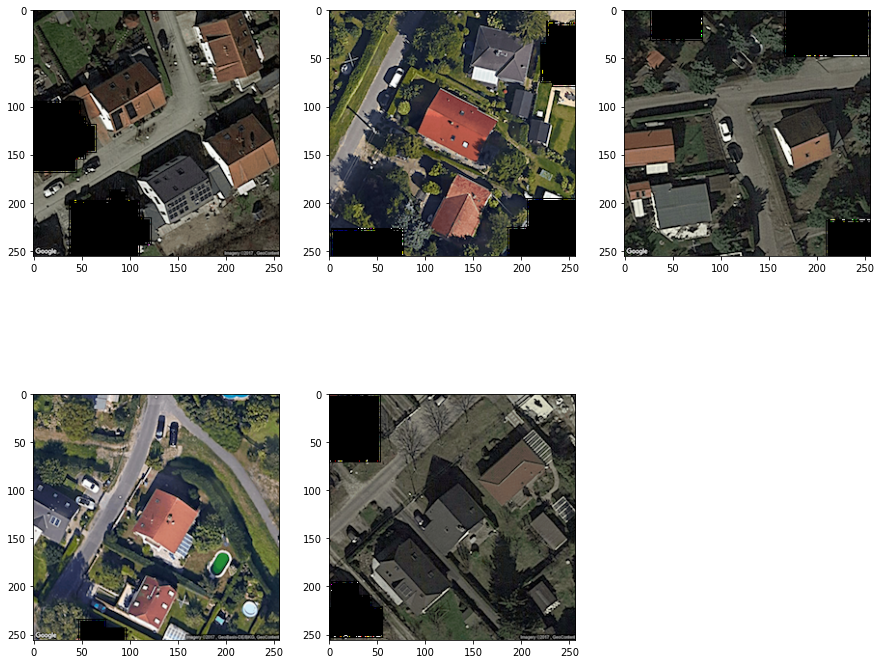

In [52]:
plt.figure(figsize = (15, 20))
for image in enumerate(data):
  plt.subplot(3, 3, image[0] + 1)
  plt.imshow(cv2.cvtColor(cv2.imread(image[1]), cv2.COLOR_BGR2RGB))
  
plt.show()

#`Plot` the testing dataset and `evaluate` the performace of the model

# of image is 1


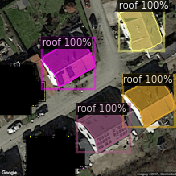

 # of image is 2


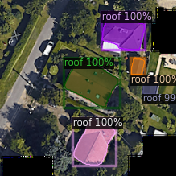

 # of image is 3


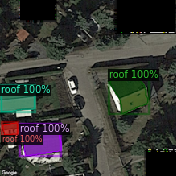

 # of image is 4


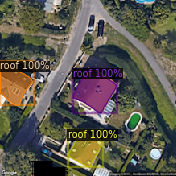

 # of image is 5


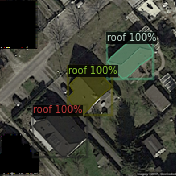

In [37]:
#### Define a function ####
def test_image_plot(activate = None):
  if activate == "activated":
    for index, image in enumerate(data):
      print("# of image is {}".format(index + 1))
      #### Read the images into NumPy array ####
      test_image = cv2.imread(image)
      #### Send the images to the predictor #####
      outputs = predictor(test_image)
      #### Visualize the test images ####
      v = Visualizer(test_image[:, :, ::-1],
                      metadata=sample_metadata, 
                        scale=0.8
      )
      #### Draw the instance to the predicted images ####
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      #### Plot the images ####
      cv2_imshow(v.get_image()[:, :, ::-1])
      print("", end = " ")

  else:
    raise Exception('There is an error'.capitalize())

#### Call the current function #####
try:
  test_image_plot(activate = "activated")
except Exception as e:
  print(e.with_traceback)


#Check the `performace` of this model

In [53]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("MASKRCNN", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "MASKRCNN")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/21 14:53:48 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/21 14:53:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/21 14:53:48 d2.data.datasets.coco]: Loaded 25 images in COCO format from /content/drive/MyDrive/detectron2maskrcnn/traindata/train.json
[03/21 14:53:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/21 14:53:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/21 14:53:48 d2.data.common]: Serializing 25 elements to byte tensors and concatenating them all ...
[03/21 14:53:48 d2.data.common]: Serialized dataset takes 0.05 MiB
[03/21 14:53:48 d2.evaluation.evaluator]: Start inference on 25 batches
[03/21 14:53:49 d2.evaluation.evaluator]: Inference done 11/25. Datal